In [1]:
import glob
import torch
import os
import math

from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

from utils.visualization_helpers import plot_image_grid, rgb2gray
from utils.evaluation_helpers import vifp_mscale
from utils.pickle_utils import load_results

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def get_most_recent_gridsearch():
    file_paths = glob.glob("data/results/*gridsearch.pkl")
    file_paths.sort()
    return file_paths[-1]

# Load Results

In [3]:
#most recent
file_path = get_most_recent_gridsearch()

#canonical
#file_path = 'data/results/2020-11-05-22:18-gridsearch.pkl'

#cameraman
#file_path = 'data/results/2020-11-06-18:51-gridsearch.pkl'


results = load_results(file_path)
print(file_path)
print('Number of Runs loaded:', len(results))

data/results/2020-11-09-13:42-gridsearch.pkl
Number of Runs loaded: 720


# Show Images

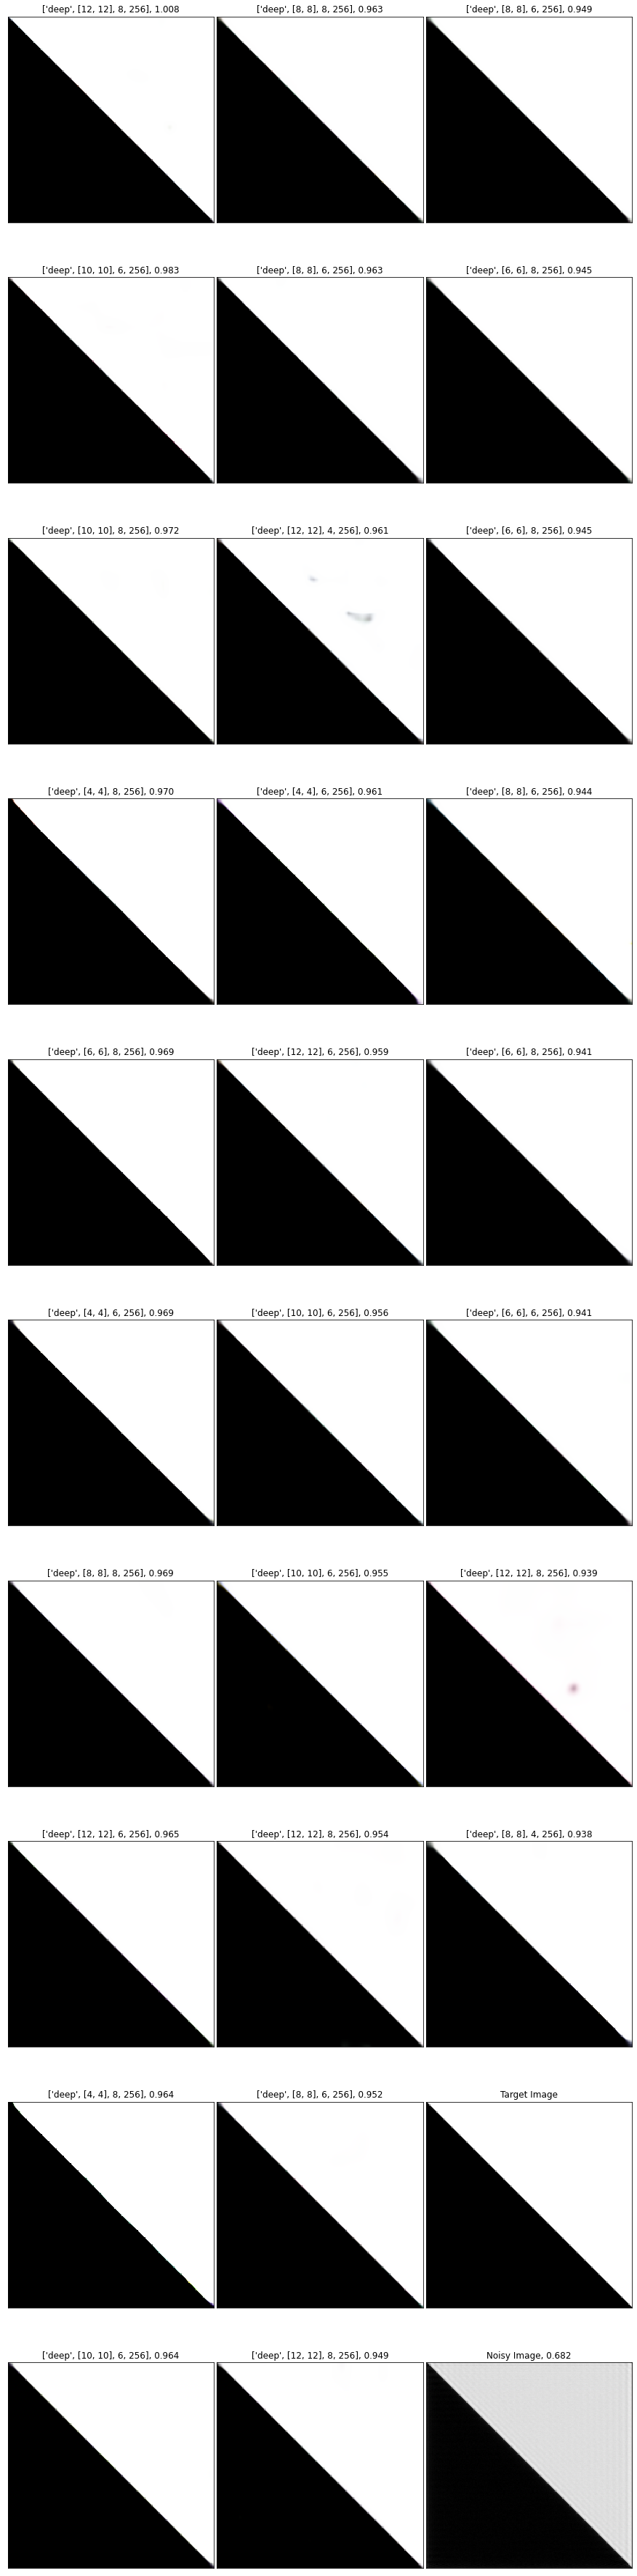

In [4]:
results.sort(key=lambda x: x.vif, reverse=True)
images = list(map(lambda x: x.model_image, results))[:28]
descriptions = list(map(lambda x: str(x.model_parameters) + f', {x.vif:.3f}', results))[:28]

target_image = results[0].target_image
images.append(target_image)
descriptions.append('Target Image')

noisy_image = results[0].noisy_image
images.append(noisy_image)
noisy_vif = vifp_mscale(target_image, noisy_image)
noisy_psnr = peak_signal_noise_ratio(target_image, noisy_image)
noisy_mse = mean_squared_error(target_image, noisy_image)
descriptions.append('Noisy Image' + f', {noisy_vif:.3f}')


plot_image_grid(images, descriptions, nrows=math.ceil(10))
plt.show()

# Reduce results to best per setting

In [5]:
losses_wrt_noisy = list(map(lambda x: mean_squared_error(noisy_image,x.model_image), results))

selected_results = []
models = []

for result, loss_wrt_noisy in zip(results, losses_wrt_noisy):
    result.best_loss_wrt_noisy = loss_wrt_noisy
    models.append(str(result.model_parameters))
models = list(dict.fromkeys(models))
models.sort()

for model in models:
    model_results = list(filter(lambda x: str(x.model_parameters) == model, results))
    model_results.sort(key=lambda x: x.best_loss_wrt_noisy)
    selected_results.append(model_results[0])

selected_results = filter(lambda x: x.vif > 0.2, selected_results)

# Plot different parameter combinations

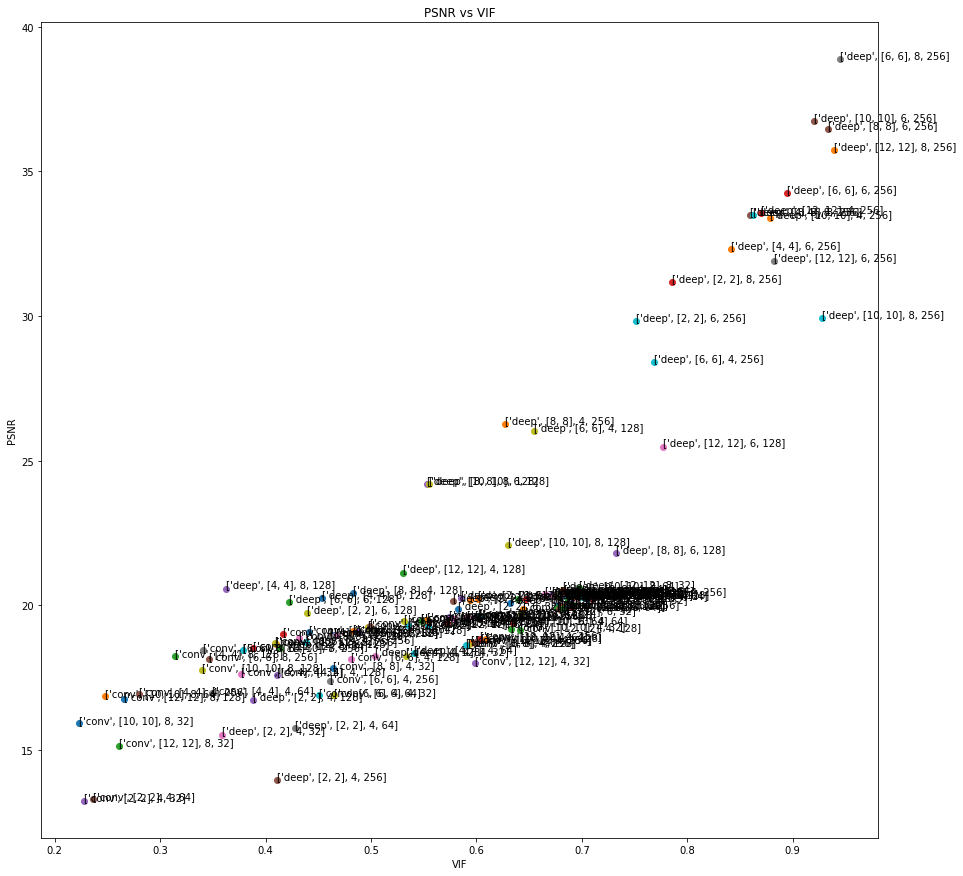

In [6]:
plt.figure(figsize=(15,15))
for selected_result in selected_results:
    plt.scatter(selected_result.vif, selected_result.psnr)
    plt.annotate(str(selected_result.model_parameters), (selected_result.vif, selected_result.psnr))
plt.scatter(noisy_vif, noisy_psnr)
plt.annotate('Noisy Image', (noisy_vif, noisy_psnr))
plt.xlabel('VIF')
plt.ylabel('PSNR')
plt.title('PSNR vs VIF')
plt.show()